# RNN for Time Series — From Scratch (NumPy) and PyTorch

This notebook implements a **Recurrent Neural Network (RNN)** in two ways:

1) **From scratch (NumPy):** a minimal RNN trained via **Backpropagation Through Time (BPTT)** on a sine‑wave time series.  
2) **PyTorch:** a compact implementation using `nn.RNN` and a linear head, trained on the same pattern.

The structure and flow of the PyTorch section follow the ideas from Codecademy’s guide *“RNN PyTorch Time Series Tutorial: Complete Guide to Implementation”*. We adapt the steps to a clean, single‑file workflow and add a matching **from‑scratch** reference for educational depth.

Source : https://www.codecademy.com/article/rnn-py-torch-time-series-tutorial-complete-guide-to-implementation


## Imports

Core scientific stack for data handling and visualization, plus PyTorch for the framework‑based model.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

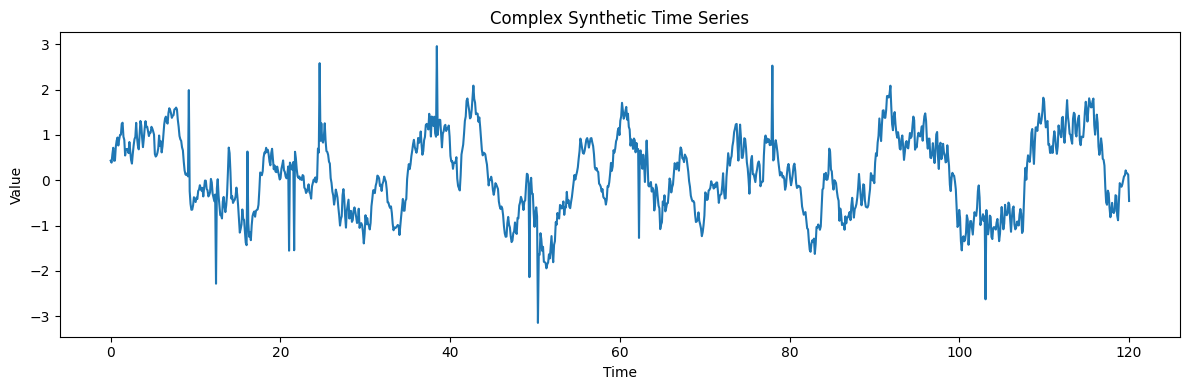

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_complex_series(n_points=1200, t_end=120.0, seed=42):
    rng = np.random.default_rng(seed)
    t = np.linspace(0.0, t_end, n_points)

    # 1) Nonlinear trend
    trend = 0.02 * (t / t_end) + 0.15 * (t / t_end) ** 2

    # 2) Multi-seasonality
    slow = 0.8  * np.sin(2*np.pi * t / 18.0)
    med  = 0.35 * np.sin(2*np.pi * t / 3.5 + 0.6)
    fast = 0.12 * np.sin(2*np.pi * t / 0.7 + 1.3)

    # 3) Chirp (frequency increases)
    f0, k = 0.03, 0.015
    chirp = 0.45 * np.sin(2*np.pi * (f0*t + 0.5 * k * (t**2) / t_end))

    # 4) Regime shift + a new high-freq after t>90
    regime = np.ones_like(t)
    regime[(t >= 40) & (t <= 70)] = 1.7
    regime_component = regime * (0.4 * np.sin(2*np.pi * t / 6.0 + 0.3))
    post90 = np.where(t > 90, 0.2 * np.sin(2*np.pi * t / 0.45), 0.0)

    # 5) Heteroscedastic AR(1) noise
    sigma_t = 0.08 + 0.12 * (np.sin(2*np.pi * t / 12.0) + 1.0) / 2.0
    rho = 0.65
    eps = np.zeros_like(t)
    base_noise = rng.normal(0.0, 1.0, size=t.shape)
    for i in range(1, len(t)):
        eps[i] = rho * eps[i-1] + sigma_t[i] * base_noise[i]

    # 6) Spikes/outliers (~1%)
    y = trend + slow + med + fast + chirp + regime_component + post90 + eps
    n_spikes = int(0.01 * n_points)
    idx = rng.choice(n_points, size=n_spikes, replace=False)
    sign = rng.choice([-1.0, 1.0], size=n_spikes)
    y[idx] += sign * 2.5 * np.std(y)

    return t, y

# Generate + plot
t, y = generate_complex_series()
df = pd.DataFrame({"time": t, "value": y})

plt.figure(figsize=(12, 4))
plt.plot(df["time"], df["value"])
plt.title("Complex Synthetic Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


## Generate a Synthetic Time Series (Sine Wave)

We will create a clean periodic signal to make learning behavior obvious.

In [46]:
df.head()

,time,value
0,0.000000,0.431460
1,0.100083,0.388322
2,0.200167,0.572984
3,0.300250,0.716230
4,0.400334,0.429198


## Visualize the Raw Series

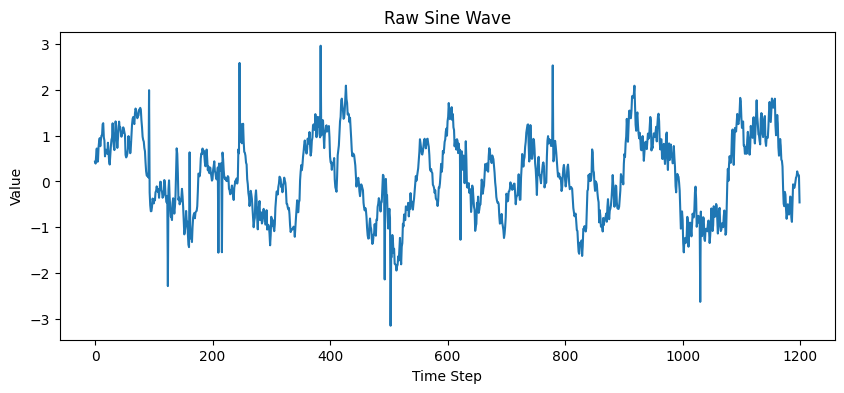

In [47]:
plt.figure(figsize=(10, 4))
plt.plot(df['value'])
plt.title("Raw Sine Wave")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.show()

## Preprocess and Create Sequences

- **Scale** values to `[0, 1]` using `MinMaxScaler`.
- **Window the series** into input sequences of length `SEQ_LEN`, with the **label** being the value immediately following the window.

In [48]:
scaler = MinMaxScaler()
df['value'] = scaler.fit_transform(df[['value']])
series = df['value'].values

def create_sequences(arr, seq_len: int):
    xs, ys = [], []
    for i in range(len(arr) - seq_len):
        x = arr[i:i+seq_len]
        y = arr[i+seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LEN = 20
X, y = create_sequences(series, SEQ_LEN)

# Split without shuffling to respect temporal order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Torch tensors for the PyTorch section
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # (batch, seq, input_size=1)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, X_test.shape

((944, 20), (236, 20))

# Part I — RNN From Scratch (NumPy)

We implement a **single‑layer tanh RNN** with a linear output head. The training objective is **MSE** between the predicted next value and the true next value.

In [49]:
class RNNFromScratch:
    def __init__(self, input_size: int, hidden_size: int, output_size: int, lr: float = 1e-2, clip: float = 5.0):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = lr
        self.clip = clip

        # Xavier-like init
        bound_in = np.sqrt(6.0 / (input_size + hidden_size))
        bound_hh = np.sqrt(6.0 / (hidden_size + hidden_size))
        bound_out = np.sqrt(6.0 / (hidden_size + output_size))

        self.Wxh = np.random.uniform(-bound_in, bound_in, (hidden_size, input_size))
        self.Whh = np.random.uniform(-bound_hh, bound_hh, (hidden_size, hidden_size))
        self.bh  = np.zeros((hidden_size,))

        self.Why = np.random.uniform(-bound_out, bound_out, (output_size, hidden_size))
        self.by  = np.zeros((output_size,))

        # Grad buffers
        self.dWxh = np.zeros_like(self.Wxh)
        self.dWhh = np.zeros_like(self.Whh)
        self.dbh  = np.zeros_like(self.bh)
        self.dWhy = np.zeros_like(self.Why)
        self.dby  = np.zeros_like(self.by)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def dtanh_from_tanh(tanh_out):
        return 1.0 - tanh_out**2

    def forward(self, x_seq):
        # x_seq: (seq_len, input_size)
        assert x_seq.ndim == 2 and x_seq.shape[1] == self.input_size

        h_prev = np.zeros((self.hidden_size,))
        hs = []
        preacts = []
        xs = []

        for t in range(x_seq.shape[0]):
            x_t = x_seq[t]
            xs.append(x_t)
            pre = np.dot(self.Wxh, x_t) + np.dot(self.Whh, h_prev) + self.bh
            h_t = self.tanh(pre)
            preacts.append(pre)
            hs.append(h_t)
            h_prev = h_t

        hs_last = hs[-1]
        y_hat = np.dot(self.Why, hs_last) + self.by  # (output_size,)
        cache = (np.array(xs), np.array(hs), np.array(preacts))
        return y_hat, cache

    def loss(self, y_hat, y_true):
        y_hat = np.asarray(y_hat).reshape(self.output_size)
        y_true = np.asarray(y_true).reshape(self.output_size)
        return 0.5 * np.square(y_hat - y_true).mean()

    def backward(self, y_hat, y_true, cache):
        xs, hs, preacts = cache
        seq_len = xs.shape[0]

        # Reset grads
        self.dWxh.fill(0.0)
        self.dWhh.fill(0.0)
        self.dbh.fill(0.0)
        self.dWhy.fill(0.0)
        self.dby.fill(0.0)

        y_hat = np.asarray(y_hat).reshape(self.output_size)
        y_true = np.asarray(y_true).reshape(self.output_size)

        dy = (y_hat - y_true)  # (output_size,)

        self.dWhy += np.outer(dy, hs[-1])
        self.dby  += dy

        dh = np.dot(self.Why.T, dy)  # (hidden_size,)

        for t in reversed(range(seq_len)):
            dtanh = self.dtanh_from_tanh(np.tanh(preacts[t]))
            dt = dh * dtanh

            h_prev = np.zeros_like(hs[0]) if t == 0 else hs[t-1]
            self.dbh  += dt
            self.dWxh += np.outer(dt, xs[t])
            self.dWhh += np.outer(dt, h_prev)

            dh = np.dot(self.Whh.T, dt)

        for g in (self.dWxh, self.dWhh, self.dbh, self.dWhy, self.dby):
            np.clip(g, -self.clip, self.clip, out=g)

    def step(self):
        self.Wxh -= self.lr * self.dWxh
        self.Whh -= self.lr * self.dWhh
        self.bh  -= self.lr * self.dbh
        self.Why -= self.lr * self.dWhy
        self.by  -= self.lr * self.dby

## Train the From‑Scratch RNN

[Scratch] Epoch 10/60  Loss: 0.001592
[Scratch] Epoch 20/60  Loss: 0.001648
[Scratch] Epoch 30/60  Loss: 0.001732
[Scratch] Epoch 40/60  Loss: 0.001561
[Scratch] Epoch 50/60  Loss: 0.001455
[Scratch] Epoch 60/60  Loss: 0.001732


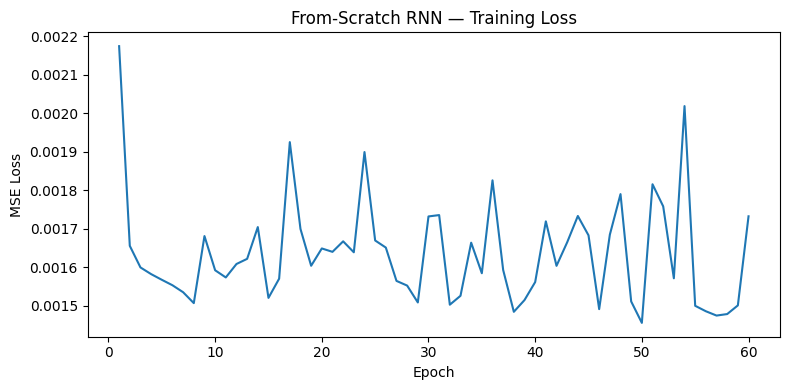

In [50]:
# Prepare NumPy views (shape: (N, seq_len, 1))
Xtr_np = X_train.reshape(X_train.shape[0], X_train.shape[1], 1).astype(np.float32)
ytr_np = y_train.reshape(-1, 1).astype(np.float32)

Xte_np = X_test.reshape(X_test.shape[0], X_test.shape[1], 1).astype(np.float32)
yte_np = y_test.reshape(-1, 1).astype(np.float32)

rnn_np = RNNFromScratch(input_size=1, hidden_size=32, output_size=1, lr=5e-2, clip=5.0)

EPOCHS = 60
losses_np = []
for ep in range(EPOCHS):
    epoch_loss = 0.0
    for i in range(len(Xtr_np)):
        xseq = Xtr_np[i]                     # (seq_len, 1)
        ytrue = ytr_np[i]                    # (1,)
        y_hat, cache = rnn_np.forward(xseq)  # y_hat: (1,)
        loss = rnn_np.loss(y_hat, ytrue)
        rnn_np.backward(y_hat, ytrue, cache)
        rnn_np.step()
        epoch_loss += float(loss)
    epoch_loss /= len(Xtr_np)
    losses_np.append(epoch_loss)
    if (ep + 1) % 10 == 0:
        print(f"[Scratch] Epoch {ep+1}/{EPOCHS}  Loss: {epoch_loss:.6f}")

plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS+1), losses_np)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("From-Scratch RNN — Training Loss")
plt.tight_layout()
plt.show()

## Evaluate (From‑Scratch)

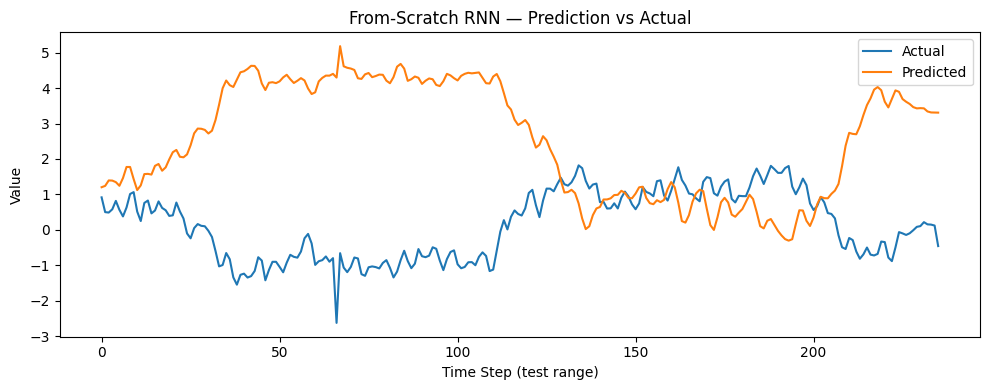

In [51]:
# Predict test set
preds_np = []
for i in range(len(Xte_np)):
    xseq = Xte_np[i]
    y_hat, _ = rnn_np.forward(xseq)
    preds_np.append(float(y_hat.reshape(-1)[0]))

preds_np = np.array(preds_np)
# Inverse transform back to original scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
pred_inv_np = scaler.inverse_transform(preds_np.reshape(-1, 1)).ravel()

plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label="Actual")
plt.plot(pred_inv_np, label="Predicted")
plt.title("From-Scratch RNN — Prediction vs Actual")
plt.xlabel("Time Step (test range)")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# Part II — RNN with PyTorch

In [52]:
class BasicRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)   # (batch, seq, hidden)
        out_last = out[:, -1, :]
        return self.fc(out_last)

model = BasicRNN(input_size=1, hidden_size=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

## Train (PyTorch)

[Torch] Epoch 10/100  Loss: 0.014244
[Torch] Epoch 20/100  Loss: 0.010276
[Torch] Epoch 30/100  Loss: 0.016237
[Torch] Epoch 40/100  Loss: 0.009020
[Torch] Epoch 50/100  Loss: 0.006149
[Torch] Epoch 60/100  Loss: 0.008295
[Torch] Epoch 70/100  Loss: 0.007220
[Torch] Epoch 80/100  Loss: 0.004506
[Torch] Epoch 90/100  Loss: 0.003199
[Torch] Epoch 100/100  Loss: 0.003113


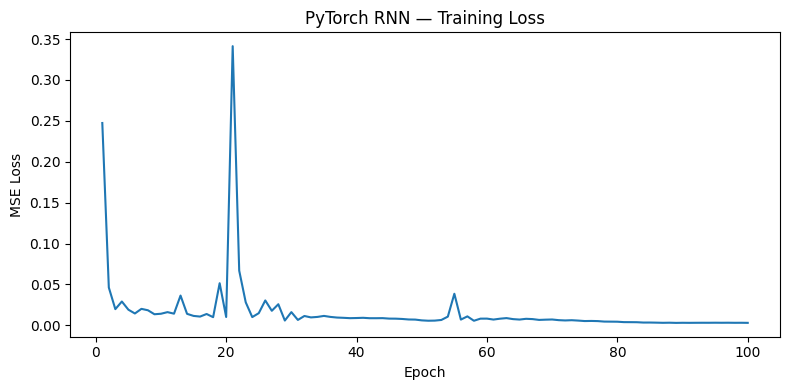

In [53]:
EPOCHS_T = 100
losses_t = []

for ep in range(EPOCHS_T):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_t).squeeze()
    loss = criterion(out, y_train_t)
    loss.backward()
    optimizer.step()

    losses_t.append(float(loss.item()))
    if (ep + 1) % 10 == 0:
        print(f"[Torch] Epoch {ep+1}/{EPOCHS_T}  Loss: {loss.item():.6f}")

plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS_T+1), losses_t)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("PyTorch RNN — Training Loss")
plt.tight_layout()
plt.show()

## Evaluate and Visualize (PyTorch)

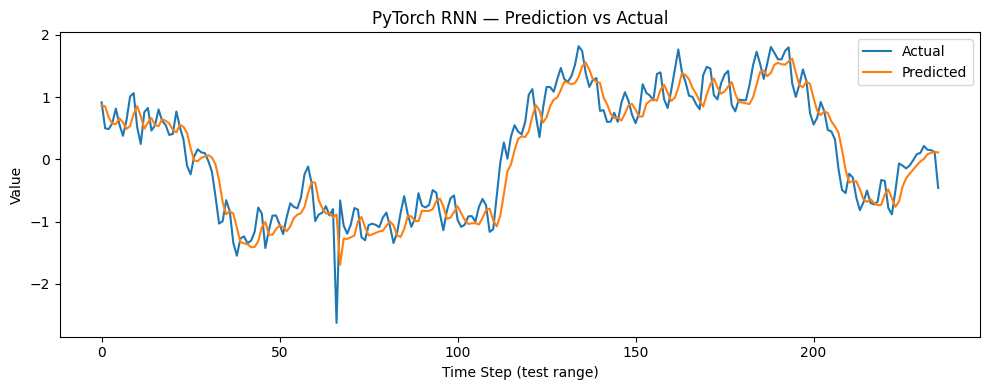

In [54]:
model.eval()
with torch.no_grad():
    preds_t = model(X_test_t).squeeze().cpu().numpy()

y_test_inv_t = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
pred_inv_t = scaler.inverse_transform(preds_t.reshape(-1, 1)).ravel()

plt.figure(figsize=(10, 4))
plt.plot(y_test_inv_t, label="Actual")
plt.plot(pred_inv_t, label="Predicted")
plt.title("PyTorch RNN — Prediction vs Actual")
plt.xlabel("Time Step (test range)")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

----
# Homework
1. ต้องการคาดการณ์กราฟการลงทุนด้วยโมเดล RNN ของตัวเอง (ใช้ PyTorch) โดยกำหนดให้ ใส่รหัสนักศึกษา 4 ตัวสุดท้ายลงในจำนวนจุดของข้อมูล (n_points) ตัวอย่างเช่น
- 66010723 ดังนั้น n_points = 723
- หากรหัสนักศึกษ 4 ตัวท้ายอยู่ในช่วง 0001-0099 ให้ใช้เลขคณะ (01) ด้วย เช่น 66010002 --> n_points = 10002

ตัวอย่างกราฟการลงทุนอ้างอิงตามฟังก์ชั่นข้างใต้

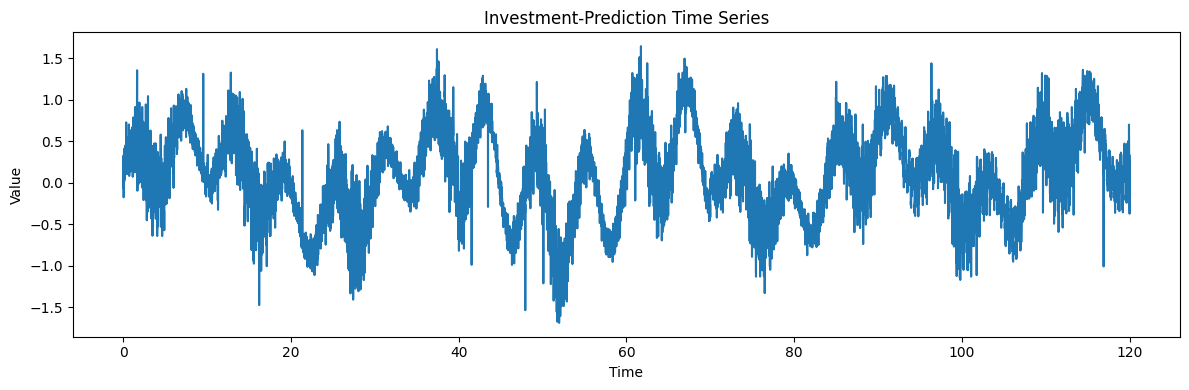

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# In case: the last four digit of student ID is 0002
def generate_complex_series(n_points=10002, t_end=120.0, seed=42):
    rng = np.random.default_rng(seed)
    t = np.linspace(0.0, t_end, n_points)

    # 1) Nonlinear trend
    trend = 0.02 * (t / t_end) + 0.15 * (t / t_end) ** 2

    # 2) Multi-seasonality
    slow = 0.001  * np.sin(2*np.pi * t / 18.0)
    med  = 0.001 * np.sin(2*np.pi * t / 3.5 + 0.6)
    fast = 0.001 * np.sin(2*np.pi * t / 0.7 + 1.3)

    # 3) Chirp (frequency increases)
    f0, k = 0.03, 0.015
    chirp = 0.45 * np.sin(2*np.pi * (f0*t + 0.5 * k * (t**2) / t_end))

    # 4) Regime shift + a new high-freq after t>90
    regime = np.ones_like(t)
    regime[(t >= 40) & (t <= 70)] = 1.7
    regime_component = regime * (0.4 * np.sin(2*np.pi * t / 6.0 + 0.3))
    post90 = np.where(t > 90, 0.2 * np.sin(2*np.pi * t / 0.45), 0.0)

    # 5) Heteroscedastic AR(1) noise
    sigma_t = 0.08 + 0.20 * (np.sin(2*np.pi * t / 12.0) + 1.0) / 2.0
    rho = 0.2
    eps = np.zeros_like(t)
    base_noise = rng.normal(0.0, 1.0, size=t.shape)
    for i in range(1, len(t)):
        eps[i] = rho * eps[i-1] + sigma_t[i] * base_noise[i]

    # 6) Spikes/outliers (~1%)
    y = (trend + slow + med + fast + chirp + regime_component + post90 + eps)
    n_spikes = int(0.001 * n_points)
    idx = rng.choice(n_points, size=n_spikes, replace=False)
    sign = rng.choice([-1.0, 1.0], size=n_spikes)
    y[idx] += sign * 2.5 * np.std(y)

    return t, y

# Generate + plot
t, y = generate_complex_series(10077)
df = pd.DataFrame({"time": t, "value": y})

plt.figure(figsize=(12, 4))
plt.plot(df["time"], df["value"])
plt.title("Investment-Prediction Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

In [56]:
scaler = MinMaxScaler()
df['value'] = scaler.fit_transform(df[['value']])
series = df['value'].values

def create_sequences(arr, seq_len: int):
    xs, ys = [], []
    for i in range(len(arr) - seq_len):
        x = arr[i:i+seq_len]
        y = arr[i+seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LEN = 20
X, y = create_sequences(series, SEQ_LEN)

# Split without shuffling to respect temporal order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Torch tensors for the PyTorch section
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # (batch, seq, input_size=1)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, X_test.shape

((8045, 20), (2012, 20))

In [60]:
class BasicRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)   # (batch, seq, hidden)
        out_last = out[:, -1, :]
        return self.fc(out_last)

model = BasicRNN(input_size=1, hidden_size=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

[Torch] Epoch 10/100  Loss: 0.043939
[Torch] Epoch 20/100  Loss: 0.020843
[Torch] Epoch 30/100  Loss: 0.022184
[Torch] Epoch 40/100  Loss: 0.017358
[Torch] Epoch 50/100  Loss: 0.014696
[Torch] Epoch 60/100  Loss: 0.012602
[Torch] Epoch 70/100  Loss: 0.009928
[Torch] Epoch 80/100  Loss: 0.005583
[Torch] Epoch 90/100  Loss: 0.005023
[Torch] Epoch 100/100  Loss: 0.004567


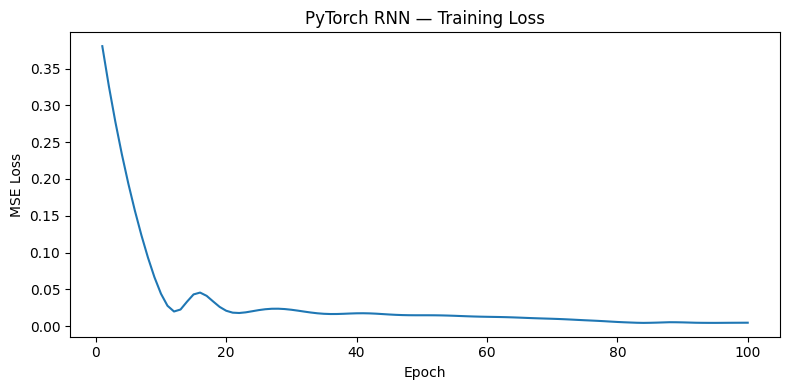

In [61]:
EPOCHS_T = 100
losses_t = []

for ep in range(EPOCHS_T):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_t).squeeze()
    loss = criterion(out, y_train_t)
    loss.backward()
    optimizer.step()

    losses_t.append(float(loss.item()))
    if (ep + 1) % 10 == 0:
        print(f"[Torch] Epoch {ep+1}/{EPOCHS_T}  Loss: {loss.item():.6f}")

plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS_T+1), losses_t)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("PyTorch RNN — Training Loss")
plt.tight_layout()
plt.show()

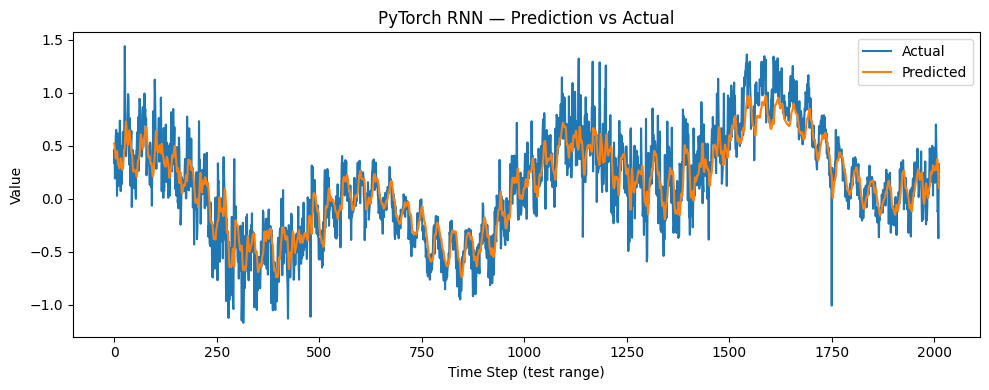

In [62]:
model.eval()
with torch.no_grad():
    preds_t = model(X_test_t).squeeze().cpu().numpy()

y_test_inv_t = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
pred_inv_t = scaler.inverse_transform(preds_t.reshape(-1, 1)).ravel()

plt.figure(figsize=(10, 4))
plt.plot(y_test_inv_t, label="Actual")
plt.plot(pred_inv_t, label="Predicted")
plt.title("PyTorch RNN — Prediction vs Actual")
plt.xlabel("Time Step (test range)")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()